**Progetto Machine Learning**

Partecipanti
- Fiorentini Nicolò  933157
- Roncoroni Samuele 935111

In questo progetto si analizza l'impatto della contaminazione dei dati sulle prestazioni dei modelli di machine learning. Dopo aver selezionato un dataset adeguato, si esegue un’analisi esplorativa e si scelgono due modelli (per classificazione o regressione). I modelli vengono inizialmente addestrati su dati puliti per stabilire una baseline. Successivamente, si introduce contaminazione progressiva nei dati tramite tecniche controllate. Infine, si valutano le prestazioni dei modelli per identificare le feature più influenti e gli effetti del rumore.

In questa situazione, non si sta cercando di fare un modello perfetto, ma di capire quanto un modello è robusto a diverse quantità di rumore introdotte artificialmente. È quindi un esperimento comparativo e controllato.

#Dataset

In [182]:
#Diamo accesso al nostro google drive che conterrà il dataset che utilizzeremo
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import requests
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy import stats

import sklearn as sn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report
)

In [183]:
url = "https://raw.githubusercontent.com/NIKFIORE/Progetto-Machine-Learning/refs/heads/main/Dataset/Cancer_Data.csv"
# Carica il dataset direttamente da GitHub
df = pd.read_csv(url)
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

# Esplorazione dei Dati (EDA)

Analizza la distribuzione delle feature, la presenza di valori mancanti, correlazioni e altre statistiche descrittive utili.

In [184]:
print(f"Numero di istanze nel dataset: {df.shape[0]}")

Numero di istanze nel dataset: 569


 📈 Ingrandimento del dataset

L’ingrandimento del dataset non è stato effettuato, in quanto le 569 istanze originali risultano sufficienti per lo scopo dello studio, che è analizzare l’effetto progressivo del rumore sulle performance del modello. Aumentare artificialmente le istanze avrebbe introdotto variabilità non controllata, con il rischio di mascherare gli effetti del rumore stesso. Si è preferito quindi mantenere il dataset originale per garantire coerenza e semplicità nell’analisi.


In [185]:
df.drop(columns=["id"], inplace= True)
df.drop(columns=["Unnamed: 32"], inplace= True)
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst             float64
fractal_dimension_worst    float64
dtype: object

In [186]:
#controllo il numero di valori duplicati
df.duplicated().sum().item()

0

In [187]:
# Verifico se ci sono valori mancanti
missing_value = df.isnull().values.any()

# Definisco x prima di usarlo
if not missing_value:
    x = "non"
else:
    x = ""

print(f"Questo dataset {x} ha valori mancanti")

Questo dataset non ha valori mancanti


In [188]:
# Controlla i valori unici nella colonna 'diagnosis'
print(df['diagnosis'].unique())

['M' 'B']


In [189]:
# Mappatura della colonna 'diagnosis'
df["diagnosis"] = df["diagnosis"].map({'B': 0, 'M': 1})
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [190]:
# Rimuove la variabile target
df_features_only = df.drop(columns=['diagnosis'])

# Ottieni automaticamente tutte le features numeriche (float)
numeric_features = df_features_only.select_dtypes(include=['float64', 'float32']).columns.tolist()
target = "diagnosis"

print(f"Features numeriche trovate: {numeric_features}")
print(f"Numero di features: {len(numeric_features)}")

Features numeriche trovate: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Numero di features: 30


Rimozione della variabile target, per la matrice di corelazione, perchè in base alla codifica, della diagnosis, avrebbe influenzato il risultato

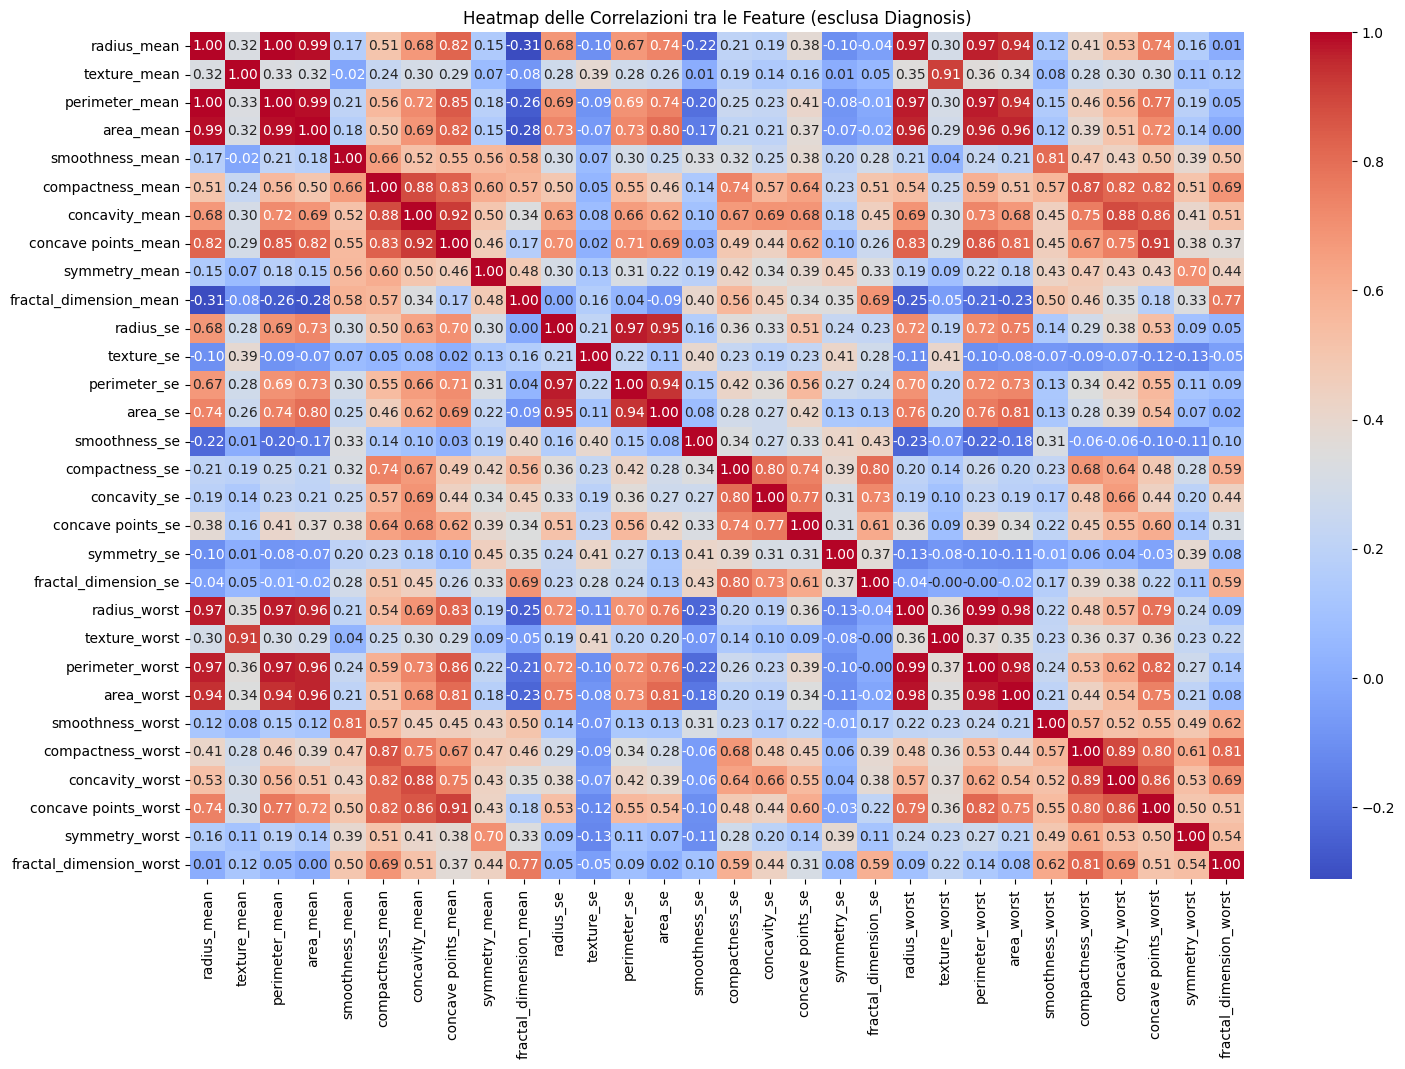

In [191]:
# Calcola la matrice di correlazione
correlation = df_features_only.corr()

# Crea la heatmap completa
plt.figure(figsize=(17, 11))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap delle Correlazioni tra le Feature (esclusa Diagnosis)')
plt.show()

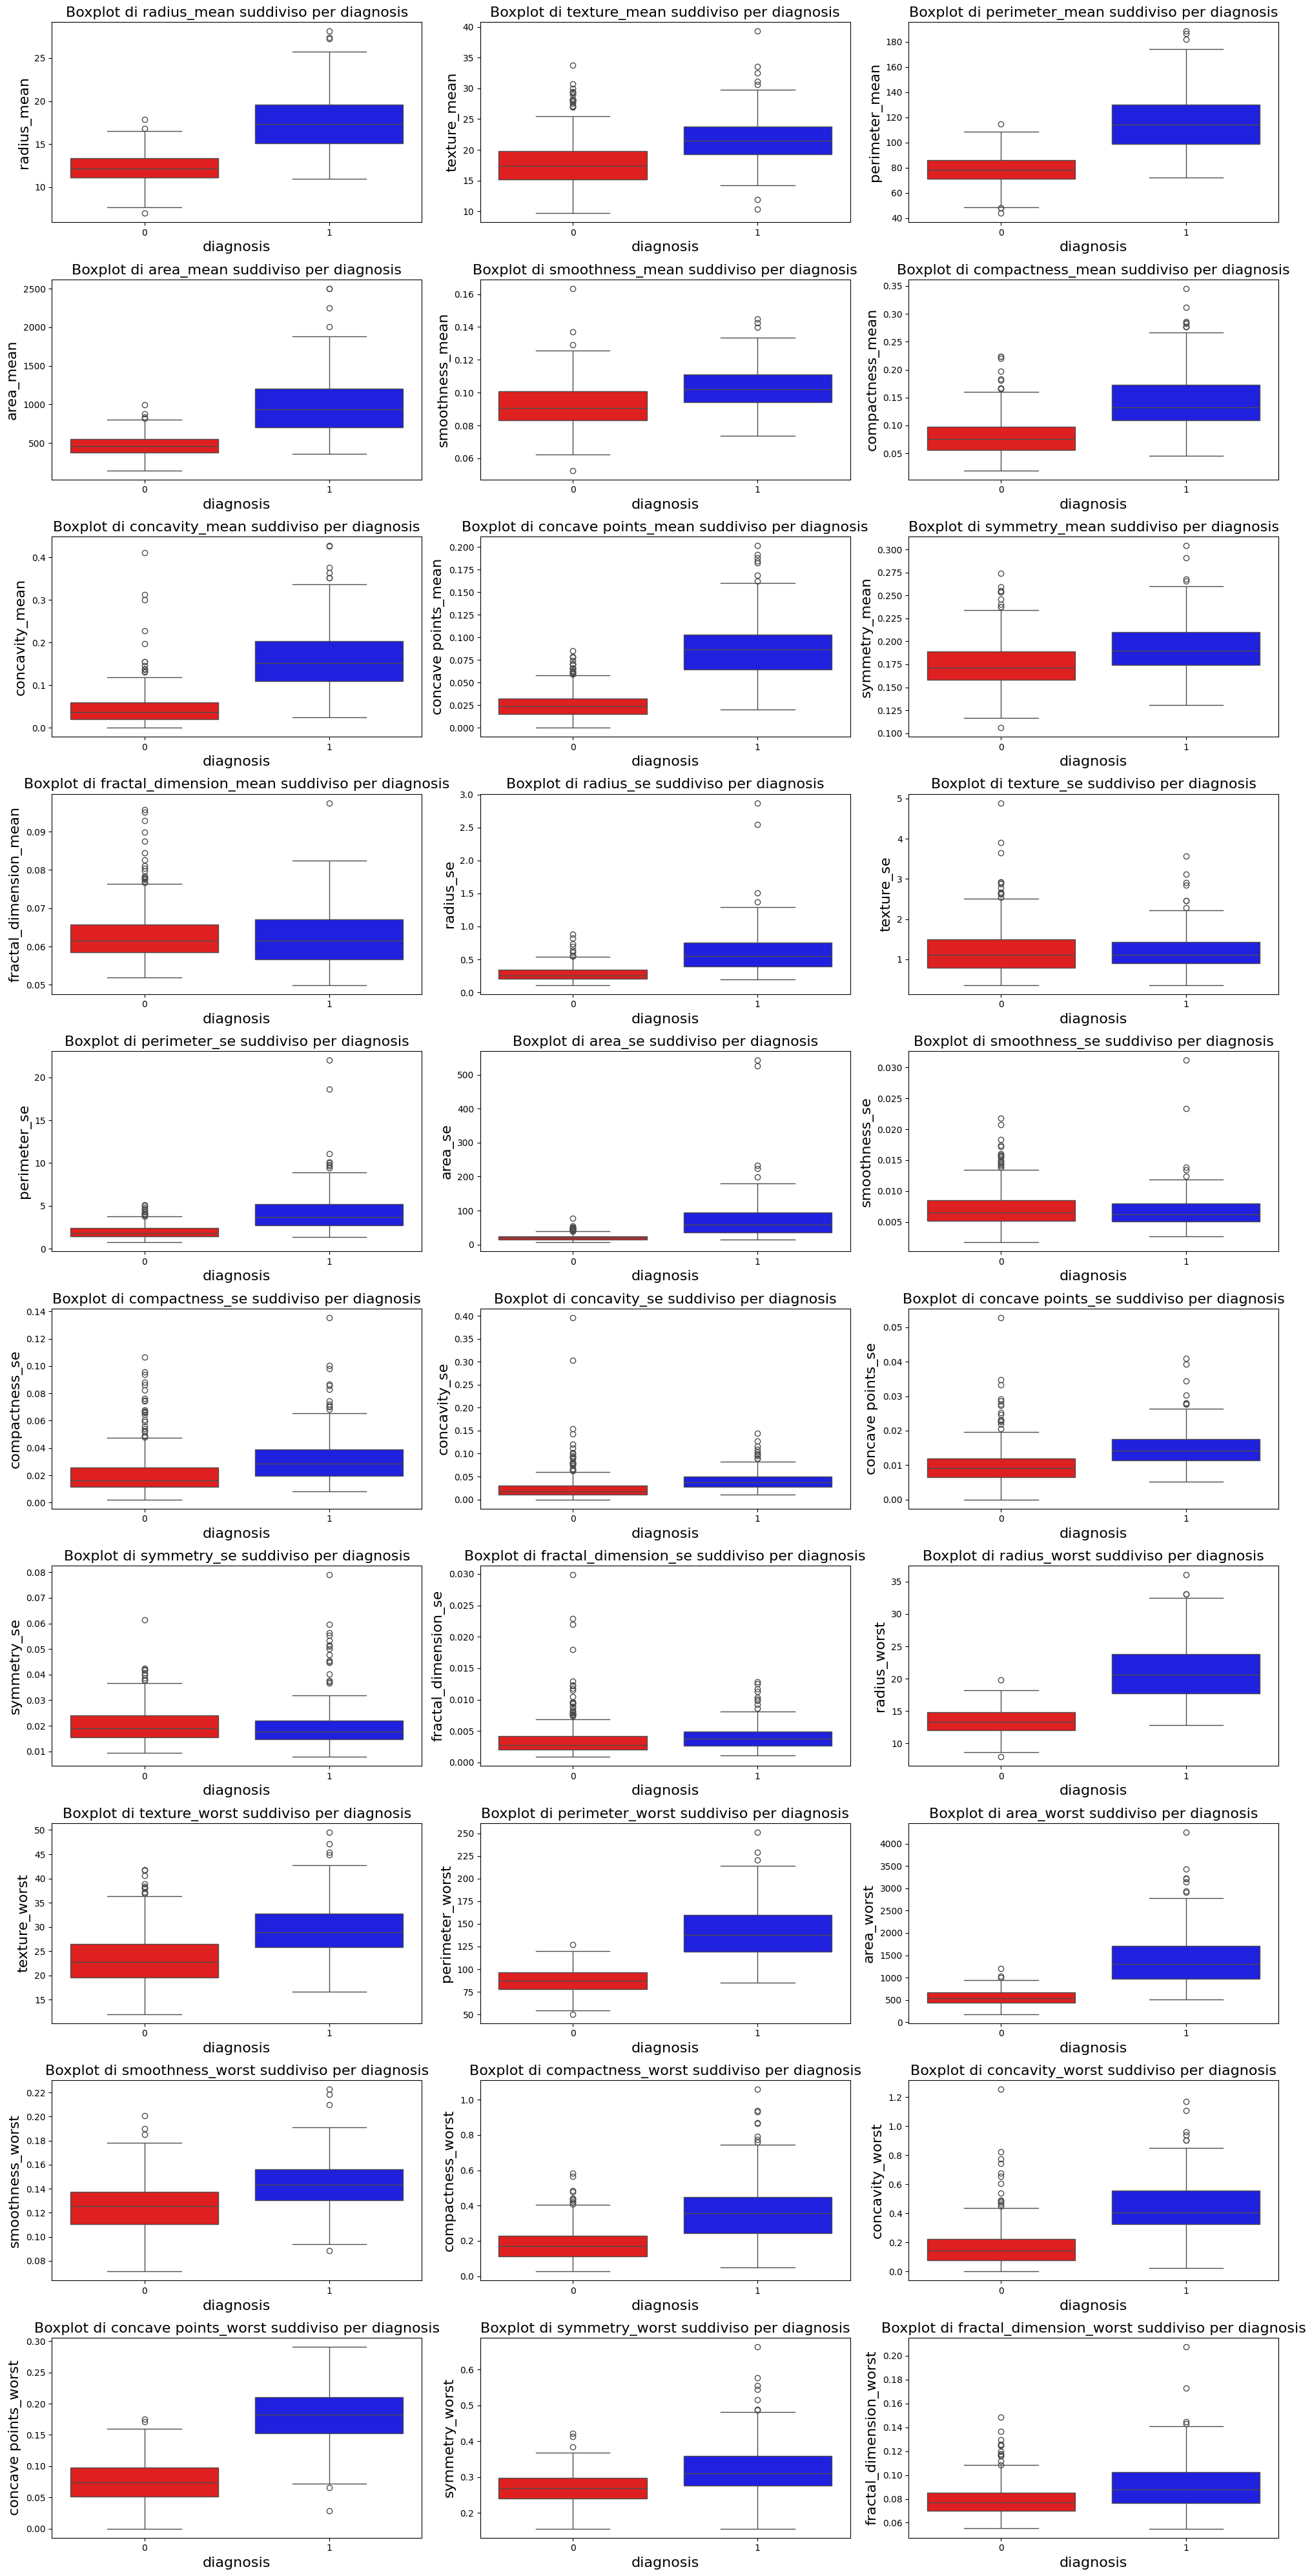

In [192]:
# Calcola il numero di righe e colonne per la griglia
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Calcolo del numero di righe necessarie

# BOXPLOT
plt.figure(figsize=(20, 4 * n_rows))  # Altezza dinamica basata sul numero di righe
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=target, y=feature, data=df, hue=target, palette=['red', 'blue'], legend=False)
    plt.title(f'Boxplot di {feature} suddiviso per {target}', fontsize=16)
    plt.xlabel(target, fontsize=16)
    plt.ylabel(feature, fontsize=16)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')

plt.tight_layout()
plt.savefig("Boxplot_Features_Numeriche.pdf")
plt.show()

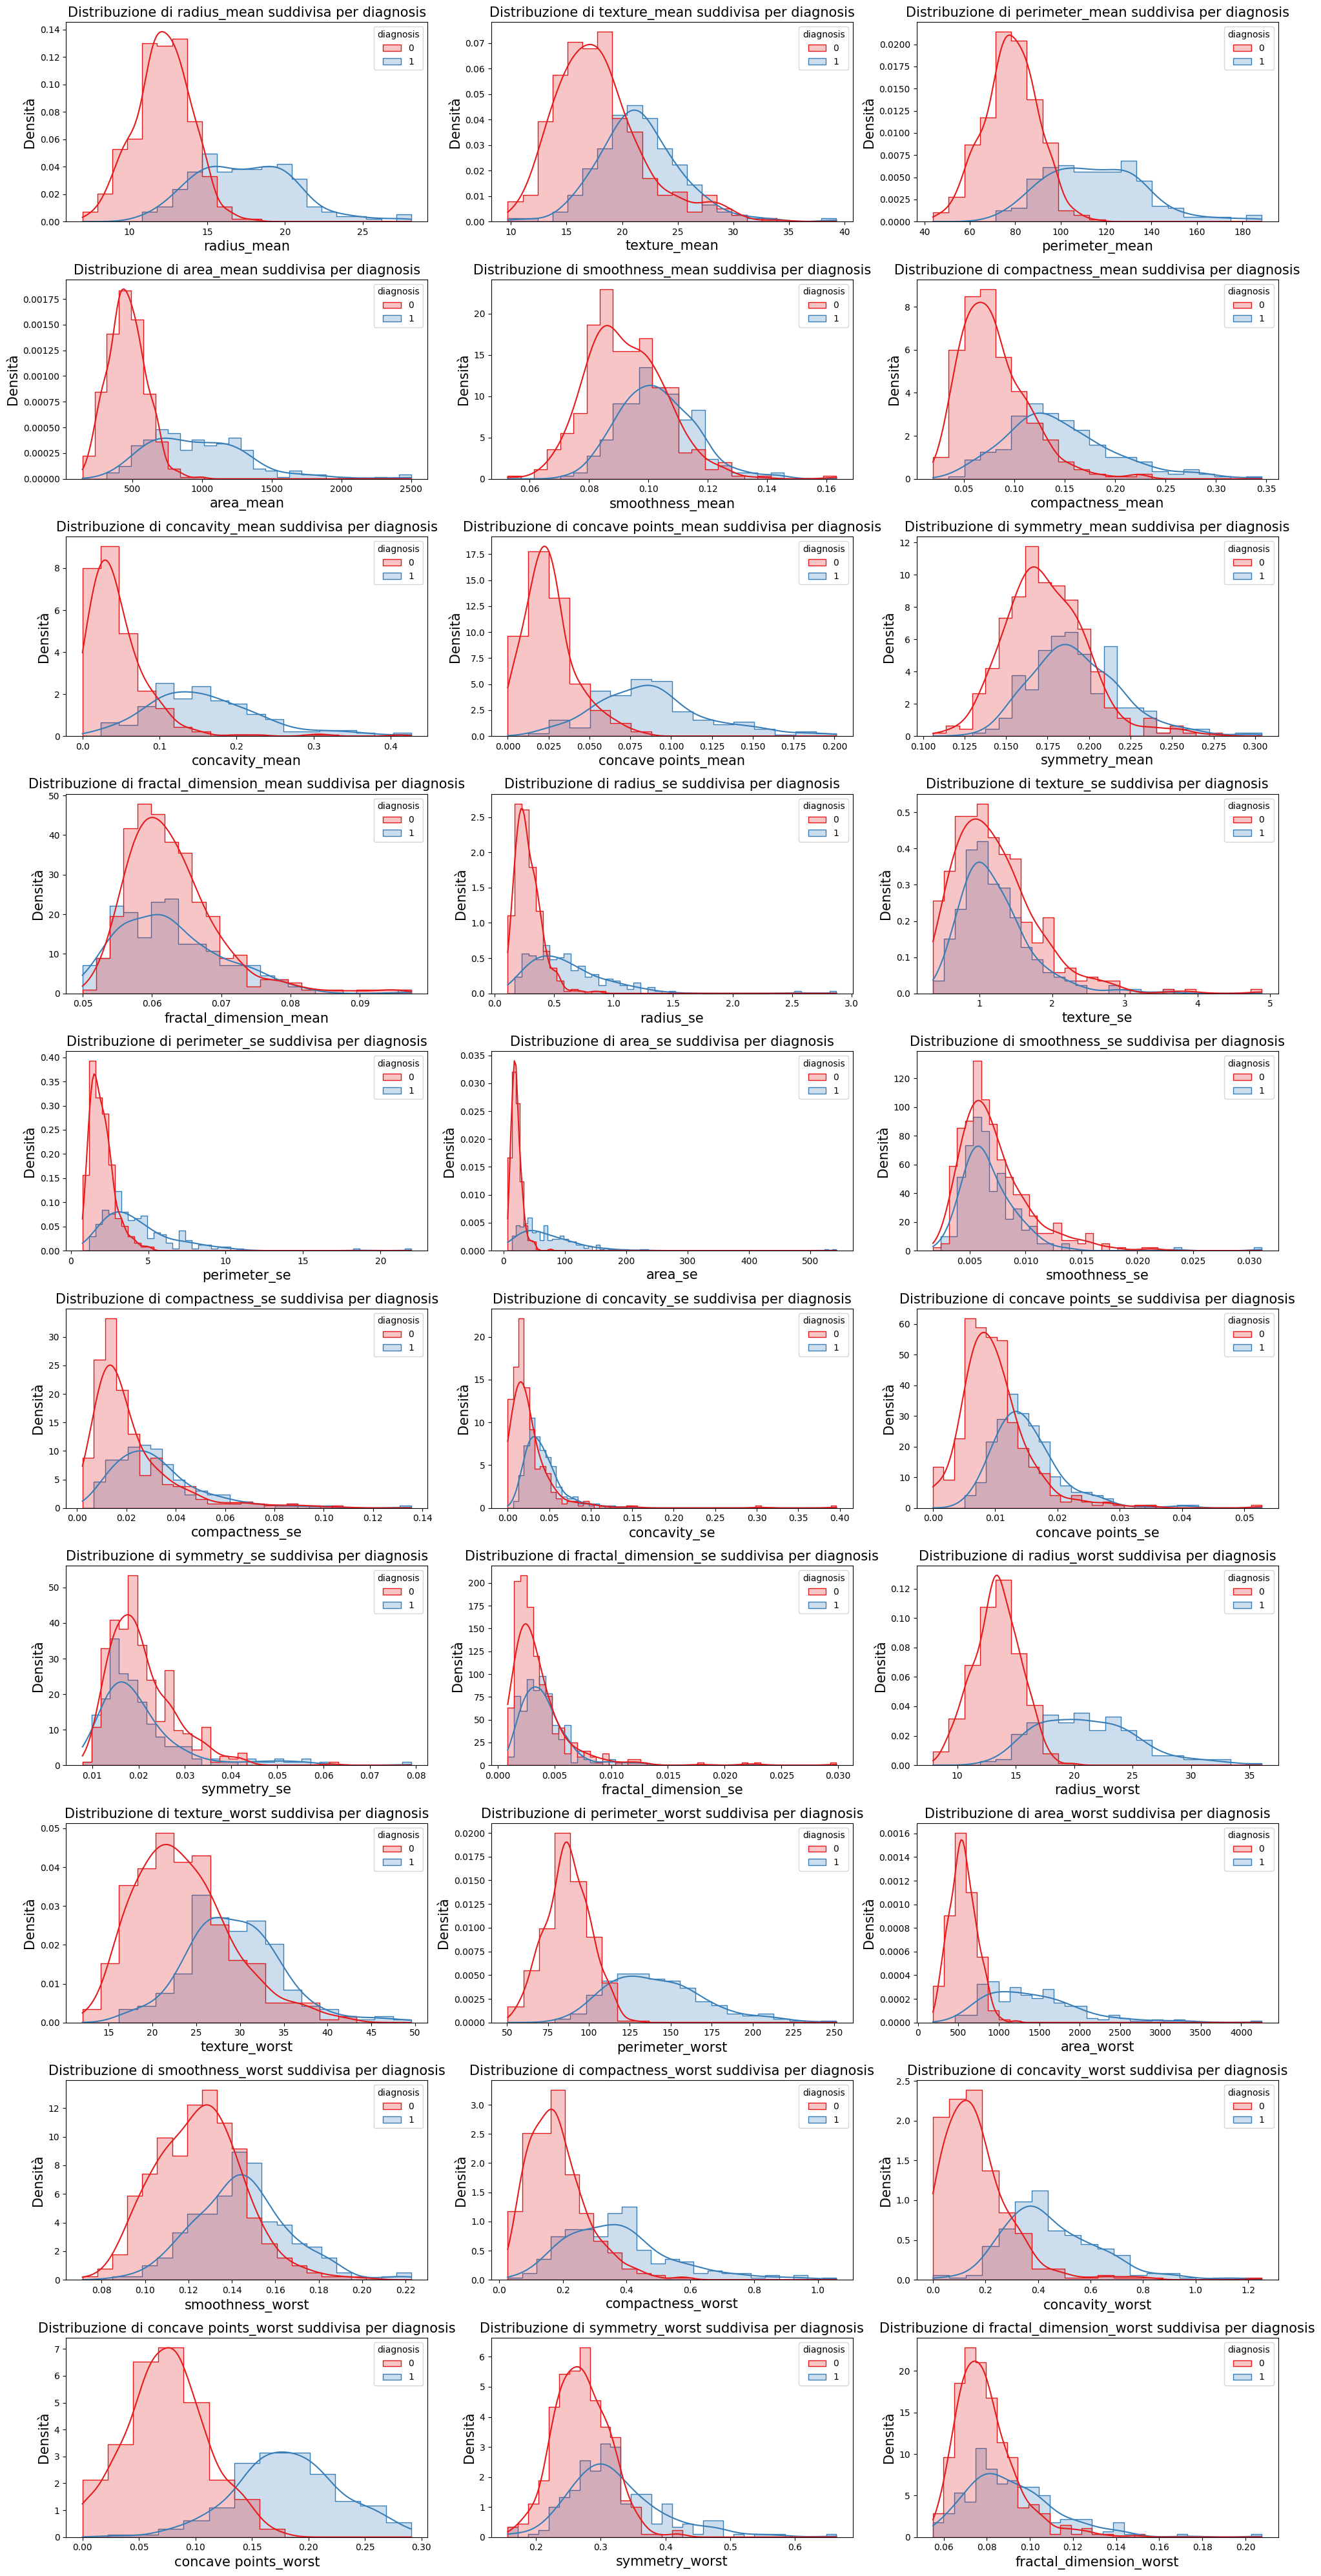

In [193]:
# GRAFICI DI DISTRIBUZIONE
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=False)

# Gestisci il caso di una sola riga
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(data=df, x=feature, hue=target, kde=True, element="step",
                palette="Set1", stat="density", ax=axes[i])
    axes[i].set_title(f"Distribuzione di {feature} suddivisa per {target}", fontsize=15)
    axes[i].set_xlabel(feature, fontsize=15)
    axes[i].set_ylabel("Densità", fontsize=15)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("Distribuzione_Features_Numeriche.pdf")
plt.show()

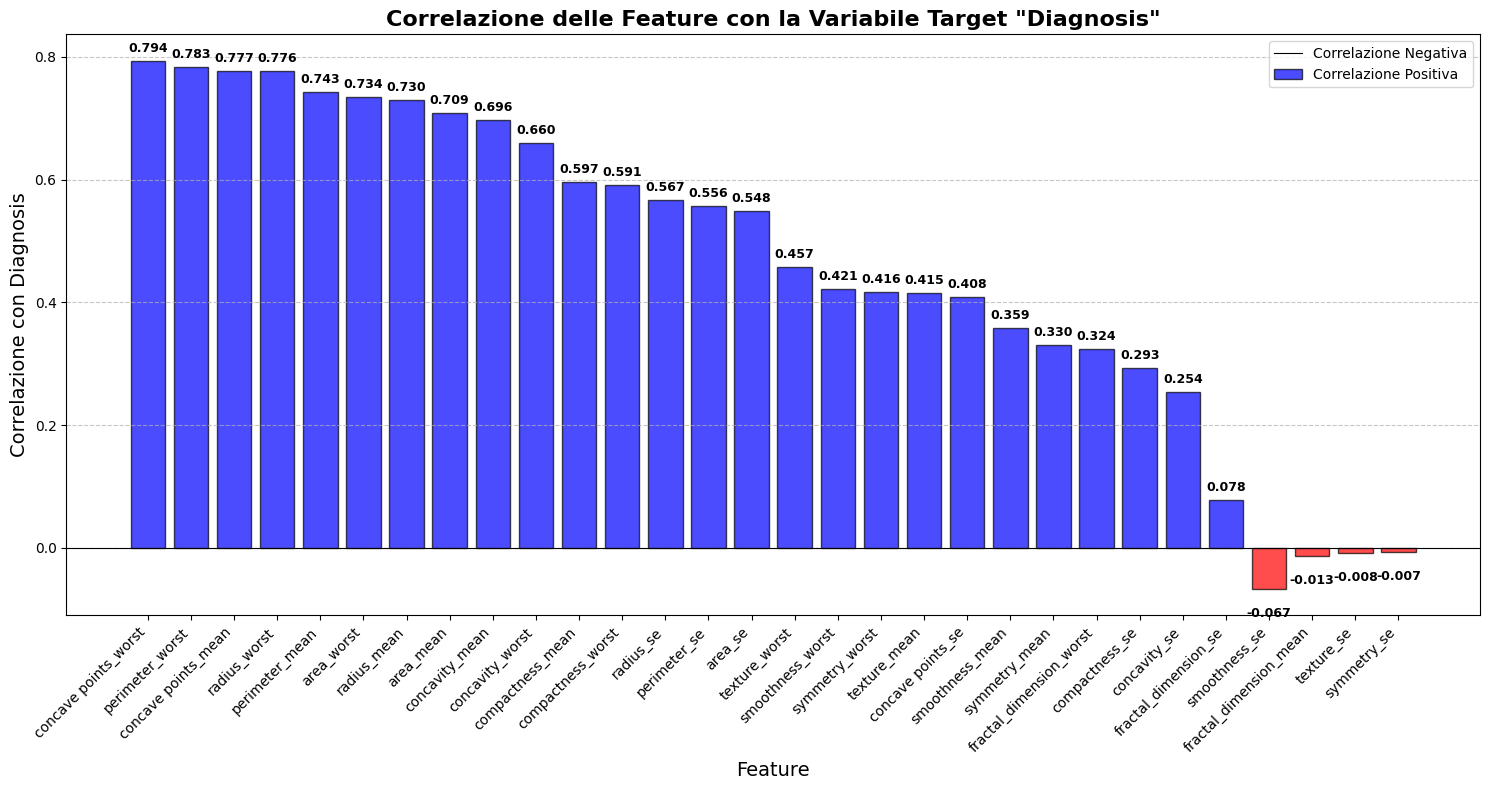


Top 10 Feature più correlate con 'Diagnosis':
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis, dtype: float64


In [194]:
# Calcola la correlazione tra tutte le feature e il target 'diagnosis'
correlations_with_target = df[numeric_features + ['diagnosis']].corr()['diagnosis'].drop('diagnosis')

# Ordina le correlazioni in valore assoluto (per vedere sia correlazioni positive che negative)
correlations_sorted = correlations_with_target.reindex(correlations_with_target.abs().sort_values(ascending=False).index)

# Crea il grafico a barre
plt.figure(figsize=(15, 8))
colors = ['red' if x < 0 else 'blue' for x in correlations_sorted.values]
bars = plt.bar(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7, edgecolor='black')

# Personalizza il grafico
plt.title('Correlazione delle Feature con la Variabile Target "Diagnosis"', fontsize=16, fontweight='bold')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Correlazione con Diagnosis', fontsize=14)
plt.xticks(range(len(correlations_sorted)), correlations_sorted.index, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Aggiungi una linea orizzontale a y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Aggiungi i valori sopra ogni barra
for i, (bar, value) in enumerate(zip(bars, correlations_sorted.values)):
   plt.text(bar.get_x() + bar.get_width()/2, value + (0.01 if value > 0 else -0.03),
            f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top', fontweight='bold', fontsize=9)

# Aggiungi una leggenda
plt.legend(['Correlazione Negativa', 'Correlazione Positiva'], loc='upper right')

plt.tight_layout()
plt.show()

# Stampa le top 10 correlazioni più forti (in valore assoluto)
print("\nTop 10 Feature più correlate con 'Diagnosis':")
print(correlations_sorted.head(10))

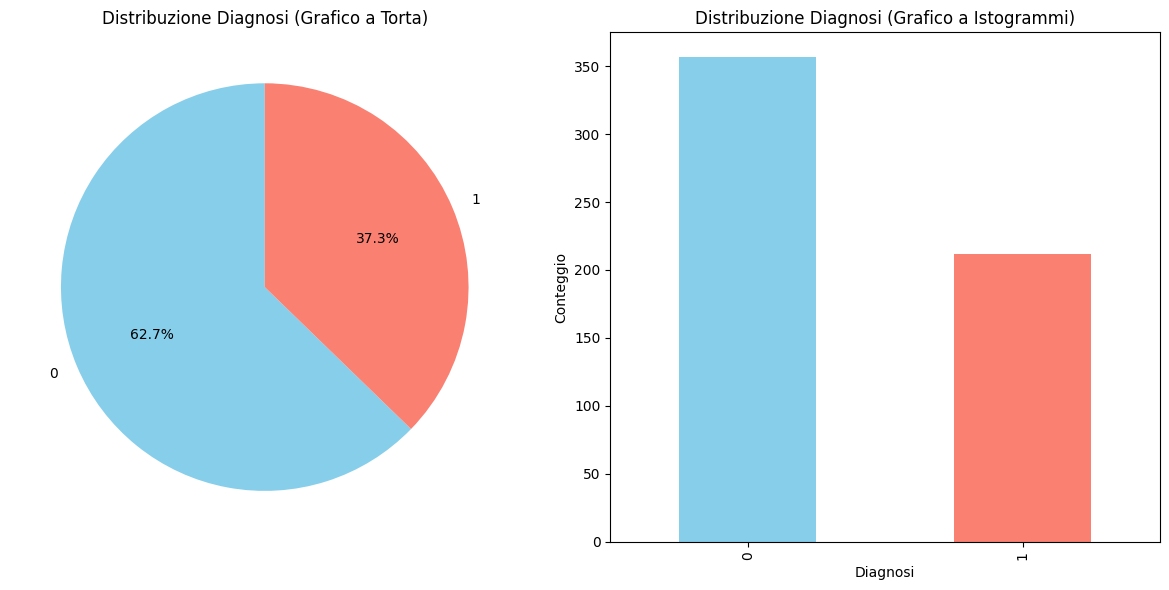

CONFRONTO DISTRIBUZIONE CLASSI:
diagnosis
0    357
1    212
Name: count, dtype: int64
Percentuale classe 0 (Benigno): 62.7%
Percentuale classe 1 (Maligno): 37.3%


In [195]:
# Plot a torta
plt.figure(figsize=(12, 6))

# Subplot 1: Grafico a torta
plt.subplot(1, 2, 1)
df['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Torta)')
plt.ylabel('')

# Subplot 2: Grafico a istogrammi
plt.subplot(1, 2, 2)
df['diagnosis'].value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Istogrammi)')
plt.xlabel('Diagnosi')
plt.ylabel('Conteggio')

# Mostra il grafico
plt.tight_layout()
plt.show()

print("CONFRONTO DISTRIBUZIONE CLASSI:")
print(df['diagnosis'].value_counts())
print(f"Percentuale classe 0 (Benigno): {df['diagnosis'].value_counts()[0]/len(df)*100:.1f}%")
print(f"Percentuale classe 1 (Maligno): {df['diagnosis'].value_counts()[1]/len(df)*100:.1f}%")

Anche se il dataset mostra un certo sbilanciamento tra le classi, questo non è particolarmente marcato. Una distribuzione del 62.7% vs 37.3% indica uno sbilanciamento moderato, che non dovrebbe influenzare negativamente in modo significativo le prestazioni dei modelli di classificazione. Tuttavia, è comunque opportuno tenere in considerazione questo aspetto durante l’addestramento, ad esempio valutando l’utilizzo di metriche appropriate (come f1-score, precision, recall)

# Preparazione dei modelli

In [196]:
# Separazione delle feature e della variabile target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split del dataset in training (80%) e test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Lo StandardScaler serve a normalizzare le feature rendendo media zero e deviazione standard uno, così i modelli come SVM e reti neurali convergono più velocemente e lavorano meglio, evitando che variabili con scale diverse influenzino troppo il risultato.

Va applicato subito dopo la suddivisione train/test per evitare il data leakage: si calcolano media e deviazione solo sul training, poi si trasformano anche i dati di test con gli stessi parametri, garantendo una valutazione corretta e imparziale dei modelli (compreso l’albero decisionale, che invece è meno sensibile alla scala, ma standardizzare aiuta uniformare il preprocessing).

In [197]:
# Inizializza lo scaler
scaler = StandardScaler()

# Adatta lo scaler ai dati di training e trasforma sia training che test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Funzione che crea e addestra i modelli

In [198]:
# Neural Network model
def create_neural_network_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),  # Use Input layer instead of specifying input_shape in Dense
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# SVM Model
def create_and_train_svm_model(X_train, y_train, kernel='rbf', C=1):
    model = SVC(kernel=kernel, C=C, probability=True)
    model.fit(X_train, y_train)
    return model

# Decision Tree Model
def create_and_train_decision_tree(X_train, y_train, random_state=42, **kwargs):
    model = DecisionTreeClassifier(random_state=random_state, **kwargs)
    model.fit(X_train, y_train)

    return model

Funzione per misurare e visionare le performance del modello

In [199]:
def evaluate_model_performance(y_true, y_pred, model_name):
    """
    Comprehensive model performance evaluation

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model

    Returns:
    - Dictionary of performance metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print detailed classification report
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred))

    # Print formatted metrics summary
    print(f"\n{model_name} - Performance Metrics Summary:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Create compact confusion matrix plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                cbar_kws={'shrink': 0.8})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=10, pad=10)
    plt.ylabel('True Label', fontsize=9)
    plt.xlabel('Predicted Label', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

    # Return metrics for visualization
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': cm[0,0],
        'False Positives': cm[0,1],
        'False Negatives': cm[1,0],
        'True Positives': cm[1,1]
    }

Funzione per mettere a confronto graficamente le metriche dei modelli

In [200]:
def plot_model_performance_metrics(metrics_list):
    """
    Create a compact visualization of model performance metrics.
    """
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Set up 2x4 grid
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')

    # Metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    # Plot the 4 main metrics
    for i, metric in enumerate(metrics):
        ax = axs[0, i]
        bars = metrics_df.plot(kind='bar', x='Model', y=metric, ax=ax, color=colors[i],
                               edgecolor='black', linewidth=1, alpha=0.7)

        ax.set_title(f'{metric}', fontweight='bold', fontsize=11)
        ax.set_ylabel(metric)
        ax.set_xlabel('')
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)

        for j, v in enumerate(metrics_df[metric]):
            ax.text(j, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Plot True Positives and True Negatives
    ax = axs[1, 0]
    true_plot = metrics_df.plot(kind='bar', x='Model', y=['True Positives', 'True Negatives'],
                                ax=ax, color=['#e74c3c', '#3498db'],
                                edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('True Positives & True Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in true_plot.containers:
        true_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # Plot False Positives and False Negatives
    ax = axs[1, 1]
    false_plot = metrics_df.plot(kind='bar', x='Model', y=['False Positives', 'False Negatives'],
                                 ax=ax, color=['#2ecc71', '#f39c12'],
                                 edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('False Positives & False Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in false_plot.containers:
        false_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # Leave the remaining 2 plots empty or use for legend/extra info
    axs[1, 2].axis('off')
    axs[1, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


# **Rete neurale e Analisi delle performance**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Neural Network - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Neural Network - Performance Metrics Summary:
Accuracy:  0.9825
Precision: 0.9762
Recall:    0.9762
F1 Score:  0.9762


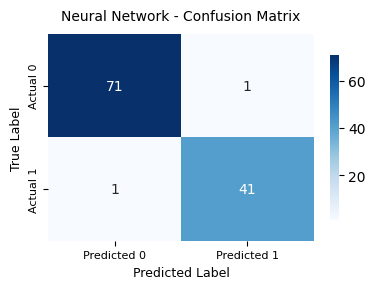

In [201]:
# Train Neural Network
input_shape = (X_train.shape[1],)
nn_model = create_neural_network_model(input_shape)
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_metrics = evaluate_model_performance(y_test, nn_pred, 'Neural Network')

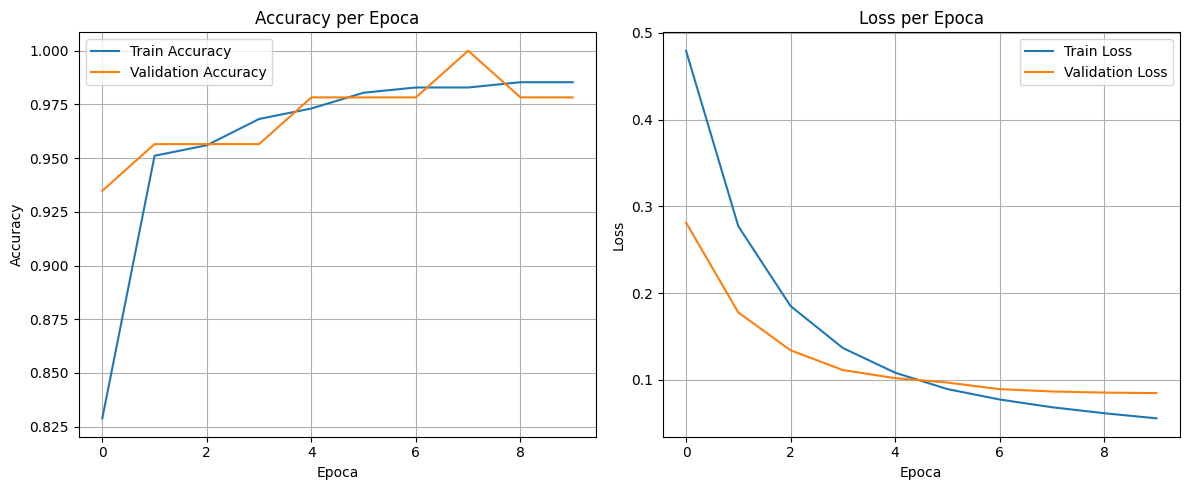

In [202]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [203]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,196 (32.02 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


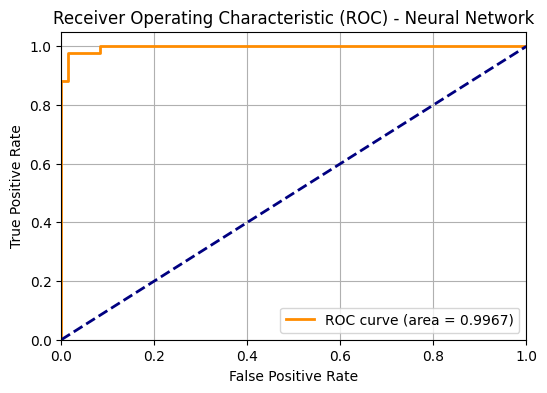

In [204]:
# Curva ROC
nn_probs = nn_model.predict(X_test).flatten()

# Calcolo curve ROC
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Neural Network')
plt.legend(loc="lower right")
plt.grid()
plt.show()

StratifiedKFold è preferibile a KFold quando si lavora con dataset sbilanciati, poiché garantisce che ogni fold mantenga la stessa proporzione di classi presente nel dataset originale. Questo è fondamentale per ottenere valutazioni più realistiche delle prestazioni del modello, soprattutto in problemi di classificazione binaria dove una classe può essere molto più rappresentata dell'altra. Al contrario, KFold divide i dati casualmente senza considerare le etichette, il che può portare a fold con solo esempi di una classe, distorcendo le metriche come accuracy, precision o recall.

Perché 5-fold è una buona scelta?
- Dataset di dimensioni medio-piccole (~569 istanze)
→ 10-fold sarebbe troppo frazionato: rischi fold troppo piccoli e instabili.

- Hai già uno split train/test
→ La cross-validation serve solo per validazione interna e confronto modelli.

- Tempo computazionale
→ Con modelli più complessi o contaminazione progressiva, 10-fold raddoppia i tempi.



Stratified K-Fold Cross Validation (5 folds)...
--------------------------------------------------
Fold 1/5
  Acc: 0.9670, Prec: 0.9697, Rec: 0.9412, F1: 0.9552
Fold 2/5
  Acc: 0.9780, Prec: 0.9444, Rec: 1.0000, F1: 0.9714
Fold 3/5
  Acc: 0.9780, Prec: 1.0000, Rec: 0.9412, F1: 0.9697
Fold 4/5
  Acc: 0.9560, Prec: 0.9412, Rec: 0.9412, F1: 0.9412
Fold 5/5
  Acc: 0.9780, Prec: 0.9706, Rec: 0.9706, F1: 0.9706
--------------------------------------------------
RISULTATI CON INTERVALLI DI CONFIDENZA (95%):
--------------------------------------------------
ACCURACY: 0.9714 [0.9592, 0.9836]
PRECISION: 0.9652 [0.9356, 0.9947]
RECALL: 0.9588 [0.9262, 0.9915]
F1: 0.9616 [0.9452, 0.9781]


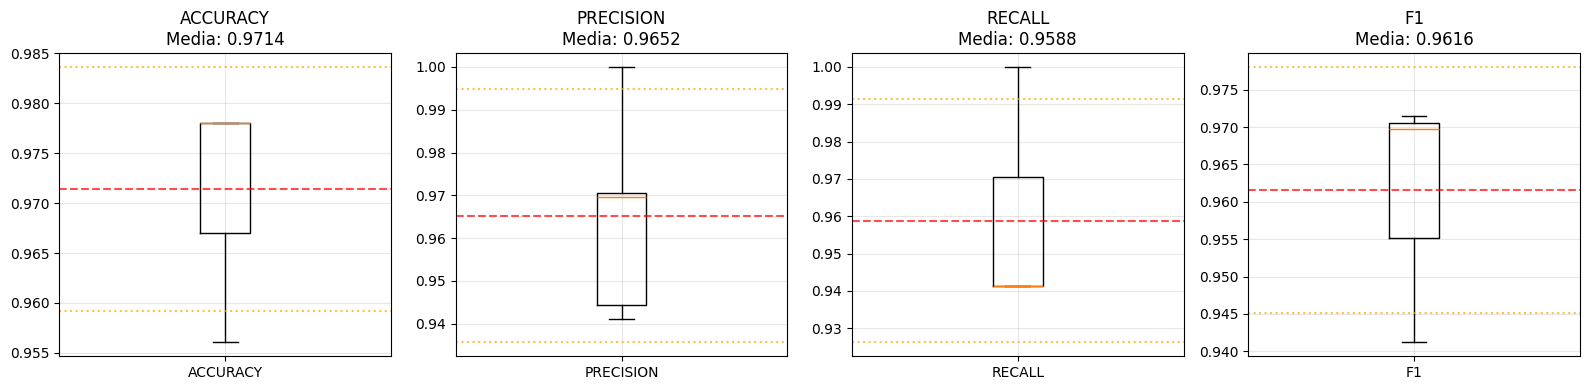


CONFRONTO CON MODELLO ORIGINALE:
--------------------------------------------------
Accuracy - Originale: 0.9825 | Cross-Val: 0.9714
F1 Score - Originale: 0.9762 | Cross-Val: 0.9616

Cross-validation completata!


In [205]:
# Stratified K-Fold Cross Validation
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

print("Stratified K-Fold Cross Validation (5 folds)...")
print("-" * 50)

# K-fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/5")

    # Split data - usa l'indicizzazione normale per NumPy arrays
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model
    fold_model = create_neural_network_model(input_shape)
    fold_model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0)

    # Predict and evaluate
    val_pred = (fold_model.predict(X_fold_val, verbose=0) > 0.5).astype(int).flatten()

    # Calculate metrics
    acc = accuracy_score(y_fold_val, val_pred)
    prec = precision_score(y_fold_val, val_pred)
    rec = recall_score(y_fold_val, val_pred)
    f1 = f1_score(y_fold_val, val_pred)

    # Store results
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1)

    print(f"  Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    keras.backend.clear_session()

print("-" * 50)

# Calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    margin = stats.sem(data) * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Results with confidence intervals
print("RISULTATI CON INTERVALLI DI CONFIDENZA (95%):")
print("-" * 50)

for metric, values in cv_scores.items():
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    print(f"{metric.upper()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Simple visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (metric, values) in enumerate(cv_scores.items()):
    ax[i].boxplot(values, tick_labels=[metric.upper()])
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    ax[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7)
    ax[i].axhline(y=ci_lower, color='orange', linestyle=':', alpha=0.7)
    ax[i].axhline(y=ci_upper, color='orange', linestyle=':', alpha=0.7)
    ax[i].set_title(f'{metric.upper()}\nMedia: {mean_val:.4f}')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick comparison with original model
print("\nCONFRONTO CON MODELLO ORIGINALE:")
print("-" * 50)
cv_mean_acc = np.mean(cv_scores['accuracy'])
original_acc = nn_metrics['Accuracy']
print(f"Accuracy - Originale: {original_acc:.4f} | Cross-Val: {cv_mean_acc:.4f}")

cv_mean_f1 = np.mean(cv_scores['f1'])
original_f1 = nn_metrics['F1 Score']
print(f"F1 Score - Originale: {original_f1:.4f} | Cross-Val: {cv_mean_f1:.4f}")

print("\nCross-validation completata!")

# **Sub vector machine e Analisi delle performance**


SVM - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


SVM - Performance Metrics Summary:
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9286
F1 Score:  0.9630


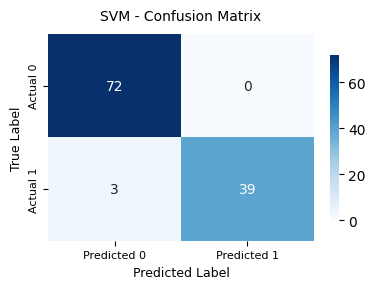

In [206]:
# Train SVM
svm_model = create_and_train_svm_model(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_metrics = evaluate_model_performance(y_test, svm_pred, 'SVM')

In [207]:
print("SVM Model parameters:")
print(svm_model.get_params())

SVM Model parameters:
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In sintesi:
- ROC misura come il modello distingue tra classi positive e negative globalmente.

- PR si concentra sulla performance relativa alla classe positiva, che è spesso la classe di interesse nei problemi sbilanciati.

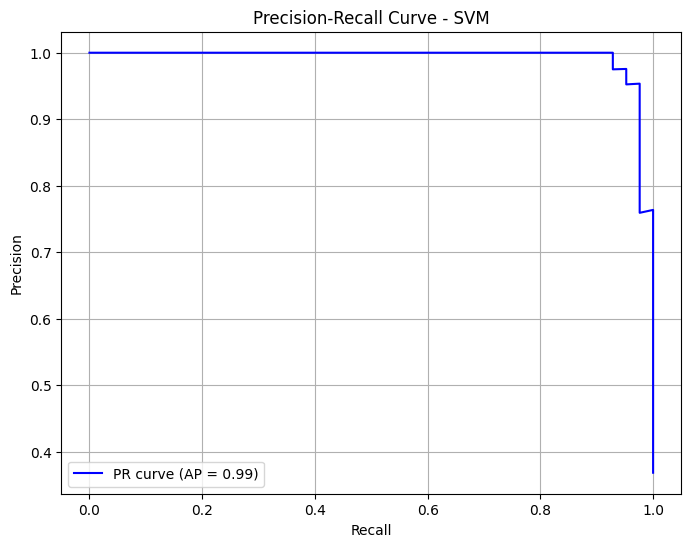

In [208]:
#Curva PR
# Calcola le probabilità previste per la classe positiva (1)
y_scores = svm_model.predict_proba(X_test)[:, 1]

# Calcola precision, recall e soglie
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcola Average Precision (area sotto la curva PR)
avg_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

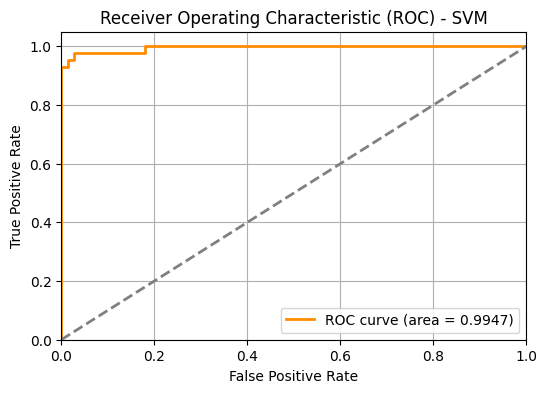

In [209]:
# Curva ROC
if hasattr(svm_model, "predict_proba"):
    svm_probs = svm_model.predict_proba(X_test)[:, 1]
else:
    # Altrimenti usa decision_function e normalizza
    svm_scores = svm_model.decision_function(X_test)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    svm_probs = scaler.fit_transform(svm_scores.reshape(-1, 1)).flatten()

# Calcolo curve ROC
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Stratified K-Fold Cross Validation (5 folds) - SVM...
--------------------------------------------------
Fold 1/5
  Acc: 0.9670, Prec: 1.0000, Rec: 0.9118, F1: 0.9538
Fold 2/5
  Acc: 0.9780, Prec: 0.9444, Rec: 1.0000, F1: 0.9714
Fold 3/5
  Acc: 0.9670, Prec: 0.9697, Rec: 0.9412, F1: 0.9552
Fold 4/5
  Acc: 0.9670, Prec: 1.0000, Rec: 0.9118, F1: 0.9538
Fold 5/5
  Acc: 0.9780, Prec: 0.9706, Rec: 0.9706, F1: 0.9706
--------------------------------------------------
RISULTATI CON INTERVALLI DI CONFIDENZA (95%):
--------------------------------------------------
ACCURACY: 0.9714 [0.9640, 0.9789]
PRECISION: 0.9769 [0.9477, 1.0061]
RECALL: 0.9471 [0.8994, 0.9947]
F1: 0.9610 [0.9496, 0.9724]


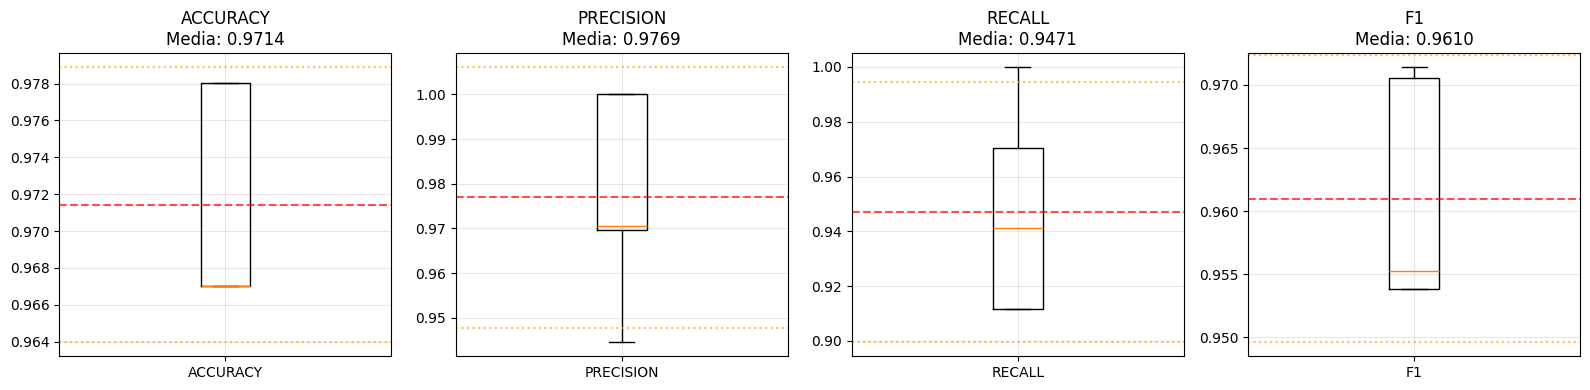


CONFRONTO CON MODELLO SVM ORIGINALE:
--------------------------------------------------
Accuracy - Originale: 0.9737 | Cross-Val: 0.9714
F1 Score - Originale: 0.9630 | Cross-Val: 0.9610

Cross-validation completata!


In [210]:
# Stratified K-Fold Cross Validation for SVM
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

print("Stratified K-Fold Cross Validation (5 folds) - SVM...")
print("-" * 50)

# K-fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/5")

    # Split data - usa l'indicizzazione normale per NumPy arrays
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train SVM model
    fold_svm_model = create_and_train_svm_model(X_fold_train, y_fold_train)

    # Predict and evaluate
    val_pred = fold_svm_model.predict(X_fold_val)

    # Calculate metrics
    acc = accuracy_score(y_fold_val, val_pred)
    prec = precision_score(y_fold_val, val_pred)
    rec = recall_score(y_fold_val, val_pred)
    f1 = f1_score(y_fold_val, val_pred)

    # Store results
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1)

    print(f"  Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

print("-" * 50)

# Calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    margin = stats.sem(data) * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Results with confidence intervals
print("RISULTATI CON INTERVALLI DI CONFIDENZA (95%):")
print("-" * 50)

for metric, values in cv_scores.items():
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    print(f"{metric.upper()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Simple visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (metric, values) in enumerate(cv_scores.items()):
    ax[i].boxplot(values, tick_labels=[metric.upper()])
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    ax[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7)
    ax[i].axhline(y=ci_lower, color='orange', linestyle=':', alpha=0.7)
    ax[i].axhline(y=ci_upper, color='orange', linestyle=':', alpha=0.7)
    ax[i].set_title(f'{metric.upper()}\nMedia: {mean_val:.4f}')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick comparison with original SVM model
print("\nCONFRONTO CON MODELLO SVM ORIGINALE:")
print("-" * 50)
cv_mean_acc = np.mean(cv_scores['accuracy'])
original_acc = svm_metrics['Accuracy']
print(f"Accuracy - Originale: {original_acc:.4f} | Cross-Val: {cv_mean_acc:.4f}")

cv_mean_f1 = np.mean(cv_scores['f1'])
original_f1 = svm_metrics['F1 Score']
print(f"F1 Score - Originale: {original_f1:.4f} | Cross-Val: {cv_mean_f1:.4f}")

print("\nCross-validation completata!")

# **Albero decisionale e Analisi delle performance**


Decision Tree - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        72
           1       0.90      0.90      0.90        42

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114


Decision Tree - Performance Metrics Summary:
Accuracy:  0.9298
Precision: 0.9048
Recall:    0.9048
F1 Score:  0.9048


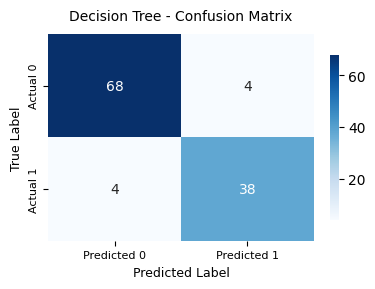

In [211]:
# Train Decision Tree
dt_model = create_and_train_decision_tree(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_metrics = evaluate_model_performance(y_test, dt_pred, 'Decision Tree')

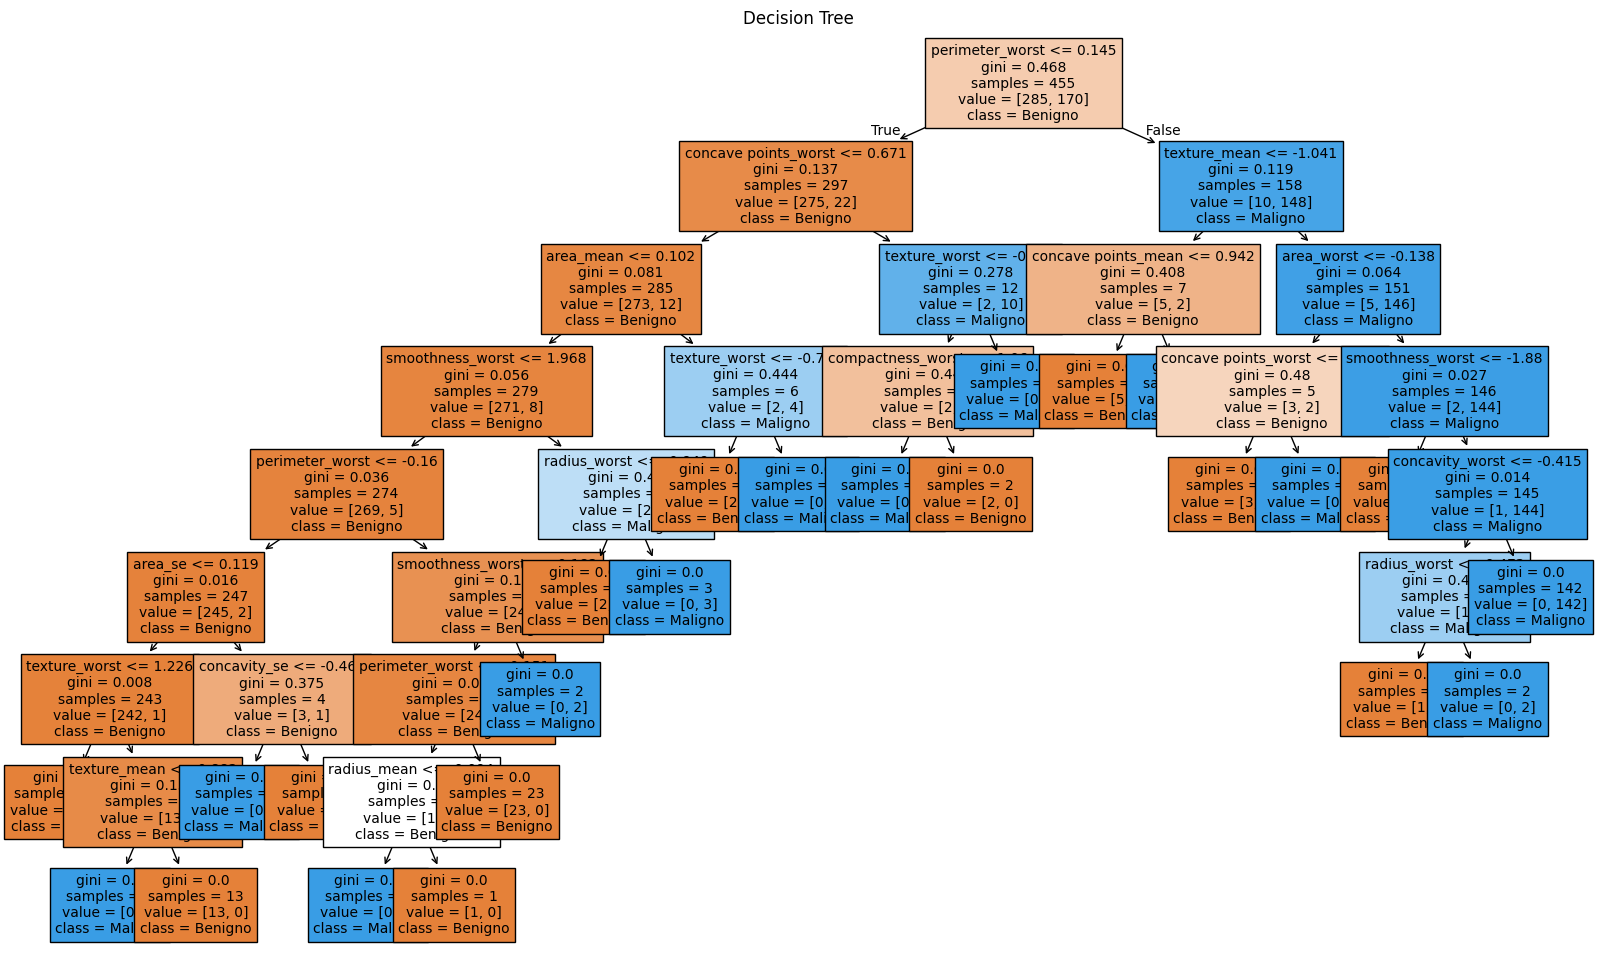

In [212]:
#Grafico rappresentativo del modello
fig, ax = plt.subplots(figsize=(20, 12))  # Dimensione più ragionevole
plot_tree(dt_model, filled=True, ax=ax, feature_names=X.columns, class_names=['Benigno', 'Maligno'], fontsize=10)
plt.title("Decision Tree")
plt.show()

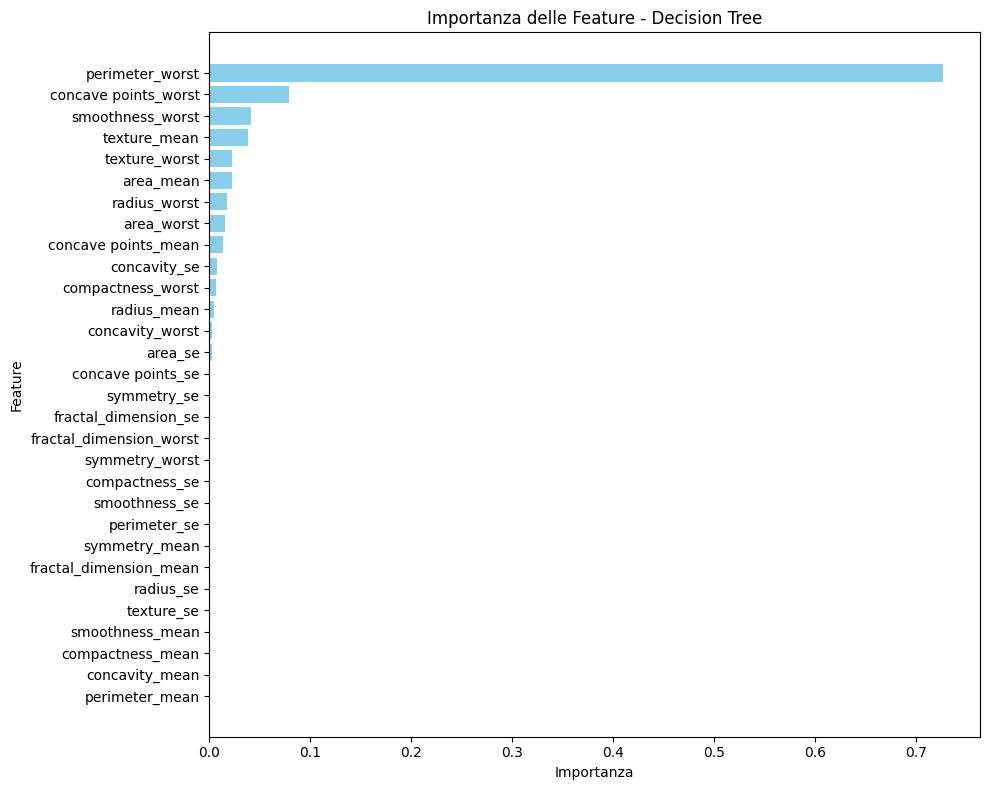

In [213]:
# Importanza feature
importances = dt_model.feature_importances_

# Ordina feature per importanza decrescente
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Grafico a barre orizzontali
plt.figure(figsize=(10, 8))
plt.title("Importanza delle Feature - Decision Tree")
plt.barh(range(len(importances)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Per avere la feature più importante in alto
plt.tight_layout()
plt.show()

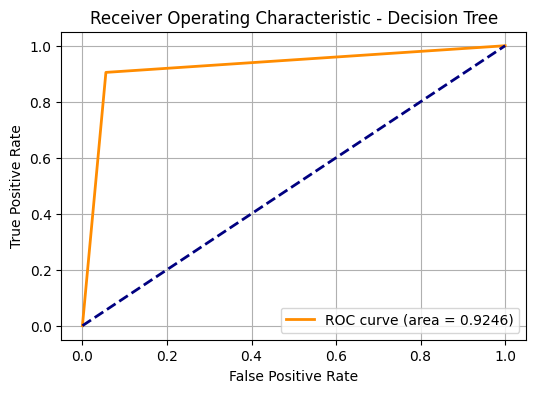

In [214]:
# Calcolo della curva ROC
y_proba = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot della curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Stratified K-Fold Cross Validation (5 folds) - Decision Tree...
--------------------------------------------------
Fold 1/5
  Acc: 0.8901, Prec: 0.8529, Rec: 0.8529, F1: 0.8529
Fold 2/5
  Acc: 0.9670, Prec: 0.9189, Rec: 1.0000, F1: 0.9577
Fold 3/5
  Acc: 0.8901, Prec: 0.8750, Rec: 0.8235, F1: 0.8485
Fold 4/5
  Acc: 0.9121, Prec: 0.8824, Rec: 0.8824, F1: 0.8824
Fold 5/5
  Acc: 0.9560, Prec: 0.9688, Rec: 0.9118, F1: 0.9394
--------------------------------------------------
RISULTATI CON INTERVALLI DI CONFIDENZA (95%):
--------------------------------------------------
ACCURACY: 0.9231 [0.8778, 0.9683]
PRECISION: 0.8996 [0.8433, 0.9559]
RECALL: 0.8941 [0.8100, 0.9782]
F1: 0.8962 [0.8341, 0.9582]


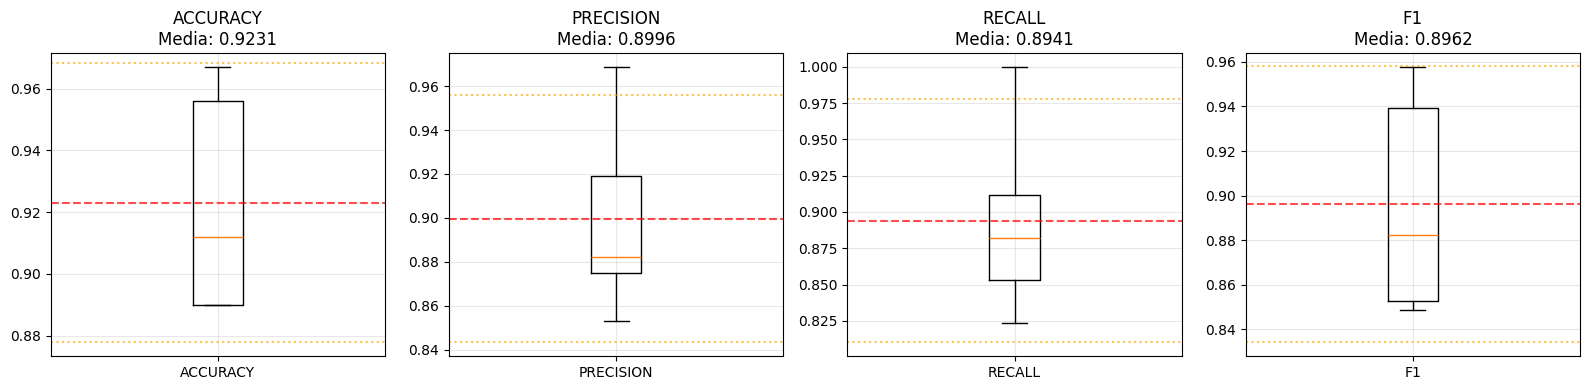


CONFRONTO CON MODELLO DECISION TREE ORIGINALE:
--------------------------------------------------
Accuracy - Originale: 0.9298 | Cross-Val: 0.9231
F1 Score - Originale: 0.9048 | Cross-Val: 0.8962

Cross-validation completata!


In [215]:
# Stratified K-Fold Cross Validation for decision tree
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

print("\nStratified K-Fold Cross Validation (5 folds) - Decision Tree...")
print("-" * 50)

# K-fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/5")

    # Split data - usa l'indicizzazione normale per NumPy arrays
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train Decision Tree model
    fold_dt_model = create_and_train_decision_tree(X_fold_train, y_fold_train)

    # Predict and evaluate
    val_pred = fold_dt_model.predict(X_fold_val)

    # Calculate metrics
    acc = accuracy_score(y_fold_val, val_pred)
    prec = precision_score(y_fold_val, val_pred)
    rec = recall_score(y_fold_val, val_pred)
    f1 = f1_score(y_fold_val, val_pred)

    # Store results
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1)

    print(f"  Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

print("-" * 50)

# Results with confidence intervals
print("RISULTATI CON INTERVALLI DI CONFIDENZA (95%):")
print("-" * 50)

for metric, values in cv_scores.items():
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    print(f"{metric.upper()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Simple visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, (metric, values) in enumerate(cv_scores.items()):
    ax[i].boxplot(values, tick_labels=[metric.upper()])
    mean_val, ci_lower, ci_upper = confidence_interval(values)
    ax[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7)
    ax[i].axhline(y=ci_lower, color='orange', linestyle=':', alpha=0.7)
    ax[i].axhline(y=ci_upper, color='orange', linestyle=':', alpha=0.7)
    ax[i].set_title(f'{metric.upper()}\nMedia: {mean_val:.4f}')
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick comparison with original Decision Tree model
print("\nCONFRONTO CON MODELLO DECISION TREE ORIGINALE:")
print("-" * 50)
cv_mean_acc = np.mean(cv_scores['accuracy'])
original_acc = dt_metrics['Accuracy']
print(f"Accuracy - Originale: {original_acc:.4f} | Cross-Val: {cv_mean_acc:.4f}")

cv_mean_f1 = np.mean(cv_scores['f1'])
original_f1 = dt_metrics['F1 Score']
print(f"F1 Score - Originale: {original_f1:.4f} | Cross-Val: {cv_mean_f1:.4f}")

print("\nCross-validation completata!")

# Confronto tra i modelli

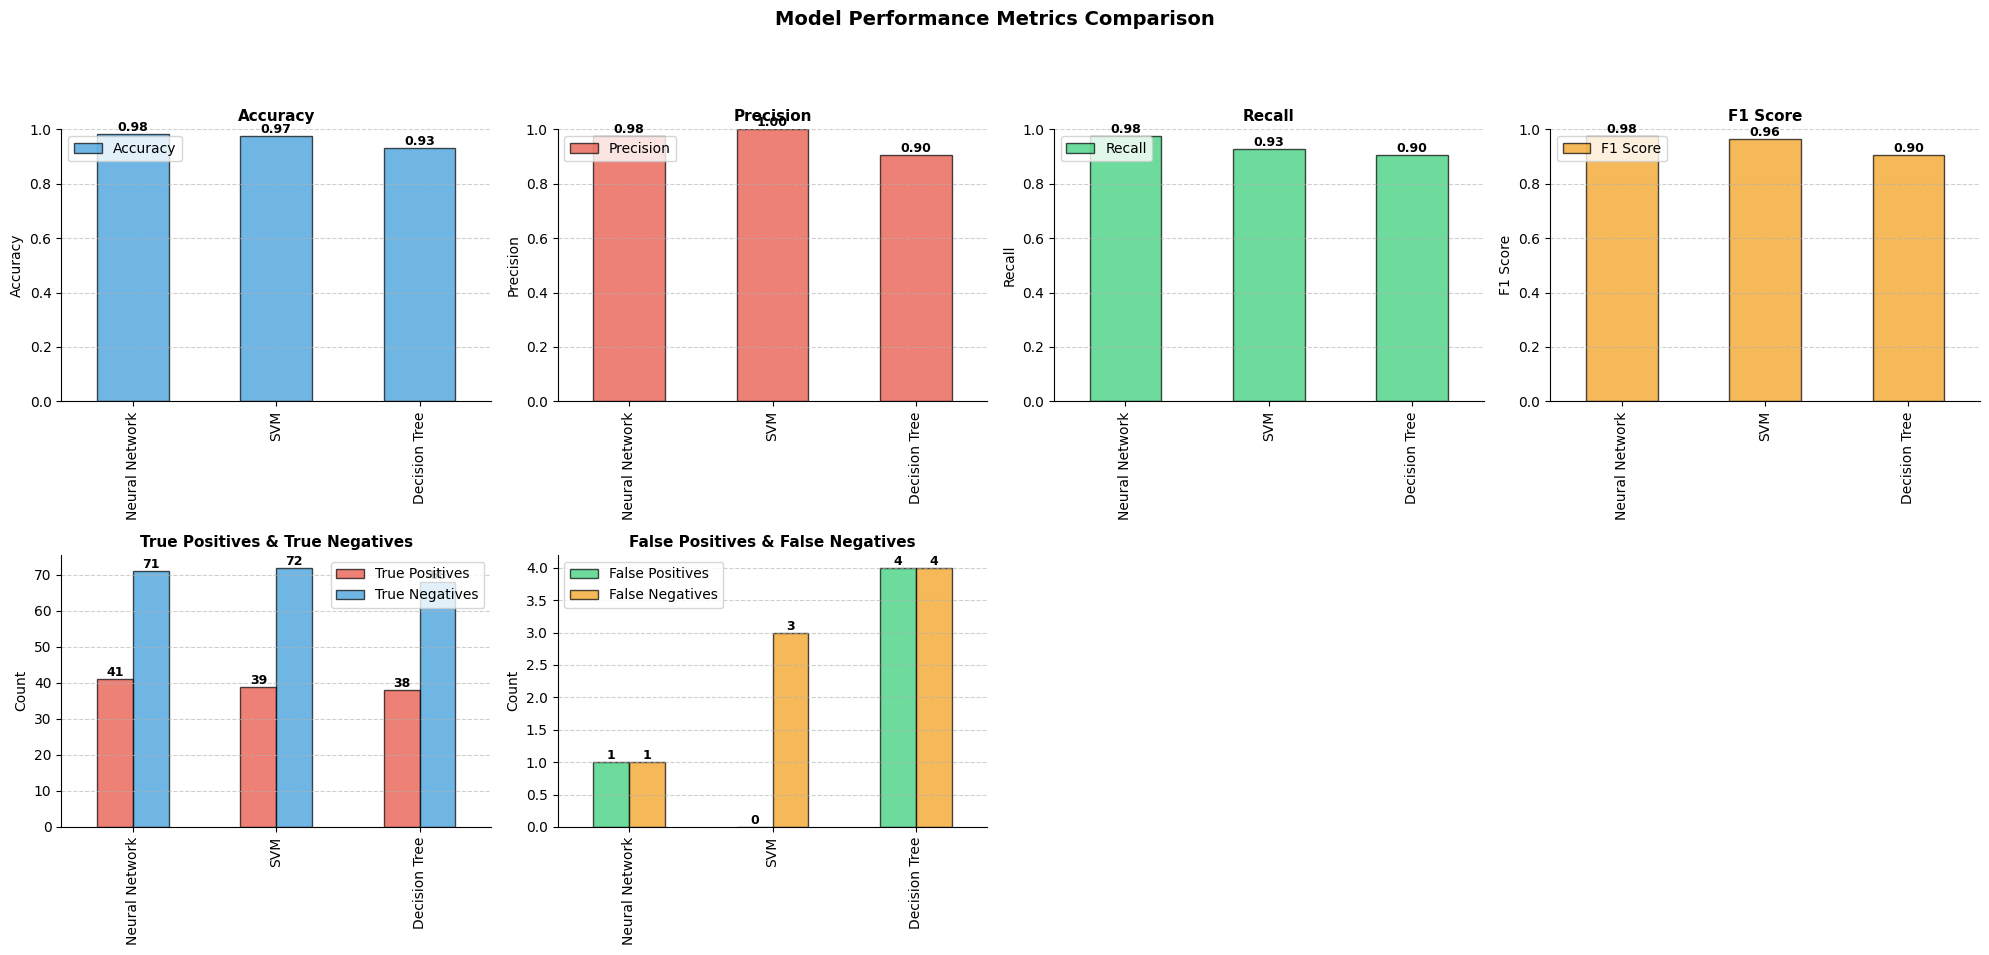

In [216]:
# Visualize Performance Metrics
plot_model_performance_metrics([nn_metrics, svm_metrics, dt_metrics])

# Sporcamento del dataset e analisi degli effetti - funzionante

Operzioni da svolgere
- valori nulli
- duplicati
- outlier

fare grafici con percentuale di sporcamento, tipologia di sporcamento e tipologia di elemento su cui viene applicato.

🎯 Obiettivo dello sporcamento <br>
Hai detto che vuoi valutare come i modelli reagiscono alla contaminazione (rumore). Quindi:

🔬 Se vuoi valutare la robustezza all’apprendimento con dati rumorosi:
➡️ Sporca solo il set di training.

Perché?

In questo caso vuoi simulare un contesto in cui il modello ha a disposizione dati di addestramento imprecisi (etichette o feature sbagliate), ma viene valutato su dati puliti.

Così misuri quanto il modello riesce a generalizzare bene nonostante il rumore in input.

🧪 Esempio realistico:<br>
- In un caso reale, potresti avere errori di annotazione nei dati raccolti (es. etichette sbagliate da medici junior), ma i test vengono eseguiti su casi noti e ben verificati.

🧪 Se sporchi anche il test set: <br>
- ➡️ Stai misurando la combinazione tra apprendimento difficile + valutazione difficile.

Problemi:

- Il modello potrebbe fare errori perché ha imparato male, ma anche perché il test è “ingiusto”.

- Le performance metriche diventano meno interpretabili: non distingui se l’errore viene dall’apprendimento o dalla valutazione.

🔴 Quindi: questo approccio è sconsigliato, a meno che tu voglia studiare scenari estremi (tipo "worst-case contamination").

✅ Conclusione chiara:
- Sporca solo il set di training, non il test.
- Il test deve rimanere pulito, così puoi valutare in modo chiaro quanto il rumore in fase di apprendimento compromette la capacità predittiva del modello.

📝 Frase utile per la relazione: <br>
“Per valutare la robustezza dei modelli all’introduzione di rumore, il rumore è stato applicato esclusivamente al set di training, mentre il set di test è rimasto intatto. Questo consente di isolare l’effetto del rumore sull’apprendimento, garantendo una valutazione equa e significativa delle prestazioni.”

Il rumore è stato applicato esclusivamente al training set, preservando il test set per una valutazione imparziale delle prestazioni. Questo approccio sistematico consente di studiare l’impatto specifico del rumore sul comportamento dei modelli, garantendo un’analisi controllata e approfondita.

Successivamente, per ciascun livello di contaminazione introdotto nel training set, è stata rieseguita una nuova validazione, mantenendo fisso e pulito il test set. Questo approccio ha permesso di valutare in modo preciso e controllato l’impatto del rumore sull’apprendimento, isolandone gli effetti e preservando una valutazione equa delle prestazioni.”

In [217]:
# ====================================================================
# FUNZIONI COMUNI - ESECUZIONE DELLO SPORCAMENTO
# ====================================================================

def train_and_evaluate_models(X_train, X_test, y_train, y_test, corruption_type, corruption_percentage):
    """
    Addestra e valuta i modelli con dati corrotti.
    """
    metrics_list = []

    # Neural Network
    print(f"\nAddestramento Neural Network con {corruption_percentage:.0%} {corruption_type}...")
    input_shape = (X_train.shape[1],)
    nn_model = create_neural_network_model(input_shape)
    history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
    nn_metrics = evaluate_model_performance(y_test, nn_pred, f'Neural Network ({corruption_percentage:.0%} {corruption_type})')
    metrics_list.append(nn_metrics)

    # SVM
    print(f"\nAddestramento SVM con {corruption_percentage:.0%} {corruption_type}...")
    svm_model = create_and_train_svm_model(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_metrics = evaluate_model_performance(y_test, svm_pred, f'SVM ({corruption_percentage:.0%} {corruption_type})')
    metrics_list.append(svm_metrics)

    # Decision Tree
    print(f"\nAddestramento Decision Tree con {corruption_percentage:.0%} {corruption_type}...")
    dt_model = create_and_train_decision_tree(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    dt_metrics = evaluate_model_performance(y_test, dt_pred, f'Decision Tree ({corruption_percentage:.0%} {corruption_type})')
    metrics_list.append(dt_metrics)

    return metrics_list


In [218]:
# ====================================================================
# FUNZIONI COMUNI - RAPPRESENTAZIONE GRAFICA DEI RISULTATI
# ====================================================================

def plot_performance_evolution(all_results, percentages, title_suffix=""):
    """
    Visualizza l'evoluzione delle performance dei modelli al variare della percentuale di sporcamento.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    performance_data = {model: {metric: [] for metric in metrics} for model in models}

    for results in all_results:
        for i, result in enumerate(results):
            model = models[i]
            for metric in metrics:
                performance_data[model][metric].append(result[metric])

    fig, axes = plt.subplots(2, 2, figsize=(18, 6))
    fig.suptitle(f'Evoluzione delle Performance dei Modelli {title_suffix}', fontsize=16, fontweight='bold')

    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        for j, model in enumerate(models):
            ax.plot(percentages, performance_data[model][metric],
                   marker='o', linewidth=2, markersize=6, label=model, color=colors[j])

        ax.set_xlabel('Percentuale Sporcamento (%)')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs Percentuale Sporcamento')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def print_statistical_analysis(all_results, corruption_type):
    """
    Stampa l'analisi statistica finale.
    """
    print(f"\n{'='*60}")
    print(f"ANALISI STATISTICA FINALE - {corruption_type.upper()}")
    print(f"{'='*60}")

    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    for i, model in enumerate(models):
        print(f"\n{model.upper()}:")
        print("-" * 40)

        for metric in metrics:
            values = [results[i][metric] for results in all_results]
            initial_value = values[0]
            final_value = values[-1]
            degradation = initial_value - final_value
            degradation_pct = (degradation / initial_value) * 100

            print(f"{metric:12}: {initial_value:.3f} → {final_value:.3f} "
                  f"(degrado: {degradation:.3f}, {degradation_pct:.1f}%)")

def plot_metrics_evolution_per_model(all_results, percentages, corruption_type):
    """
    Mostra l'andamento delle metriche per ogni modello dopo ogni sporcamento.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']  # Rosso, Blu, Verde, Arancione

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Evoluzione Metriche per Modello - {corruption_type.title()}', fontsize=16, fontweight='bold')

    for i, model in enumerate(models):
        ax = axes[i]

        # Estrai i valori delle metriche per questo modello
        for j, metric in enumerate(metrics):
            values = [results[i][metric] for results in all_results]
            ax.plot(percentages, values, marker='o', linewidth=2,
                   markersize=6, label=metric, color=colors[j])

        ax.set_xlabel('Percentuale Sporcamento (%)')
        ax.set_ylabel('Valore Metrica')
        ax.set_title(f'{model}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

        # Formatta asse x come percentuale
        ax.set_xticks(percentages[::2])
        ax.set_xticklabels([f'{p:.0%}' for p in percentages[::2]])

    plt.tight_layout()
    plt.show()

# Valori nulli

In [219]:
# ====================================================================
# FUNZIONI SPORCAMENTO VALORI NULLI
# ====================================================================

def introduce_missing_data(dataset, percentage):
    """
    Introduce valori nulli in modo casuale nel dataset (array NumPy).
    """
    # Crea una copia del dataset
    dataset_with_nulls = dataset.copy()

    # Calcola il numero di valori da rendere nulli
    total_elements = dataset_with_nulls.shape[0] * dataset_with_nulls.shape[1]
    num_missing = int(total_elements * percentage)

    # Genera indici casuali per i valori da rendere nulli
    indices = np.random.choice(total_elements, size=num_missing, replace=False)

    # Converti gli indici lineari in indici 2D
    rows, cols = np.unravel_index(indices, dataset_with_nulls.shape)

    # Imposta i valori a NaN
    dataset_with_nulls[rows, cols] = np.nan

    return dataset_with_nulls

def handle_missing_values(X_train, X_test, imputer_type='simple'):
    """
    Gestisce i valori mancanti utilizzando SimpleImputer per array NumPy.
    """
    if imputer_type == 'simple':
        imputer = SimpleImputer(strategy='mean')
    elif imputer_type == 'knn':
        imputer = KNNImputer(n_neighbors=5)

    # Applica l'imputer
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    return X_train_imputed, X_test_imputed

In [220]:
# ====================================================================
# ANALISI VALORI NULLI
# ====================================================================

print("="*60)
print("ANALISI DELL'IMPATTO DEI VALORI MANCANTI SULLE PERFORMANCE")
print("="*60)

missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
missing_results = []

for missing_pct in missing_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {missing_pct:.0%} VALORI MANCANTI")
    print(f"{'='*50}")

    # Introduce valori mancanti
    X_train_missing = introduce_missing_data(X_train, missing_pct)

    # Conta i valori mancanti
    missing_count = np.isnan(X_train_missing).sum()
    total_values = X_train_missing.shape[0] * X_train_missing.shape[1]
    actual_missing_pct = missing_count / total_values

    print(f"Valori mancanti introdotti: {missing_count}/{total_values} ({actual_missing_pct:.1%})")

    # Gestisci valori mancanti
    X_train_clean, X_test_clean = handle_missing_values(X_train_missing, X_test, imputer_type='simple')

    # Addestra e valuta
    results = train_and_evaluate_models(X_train_clean, X_test_clean, y_train, y_test, 'valori mancanti', missing_pct)
    missing_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {missing_pct:.0%} valori mancanti:")
    plot_model_performance_metrics(results)

ANALISI DELL'IMPATTO DEI VALORI MANCANTI SULLE PERFORMANCE

ANALISI CON 10% VALORI MANCANTI
Valori mancanti introdotti: 1298/13650 (9.5%)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# Visualizzazione finale
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - VALORI MANCANTI")
print("="*60)

plot_performance_evolution(missing_results, missing_percentages, "- Valori Mancanti")

In [ ]:
print_statistical_analysis(missing_results, "valori mancanti")

In [ ]:
plot_metrics_evolution_per_model(missing_results, missing_percentages, "valori mancanti")

# Valori duplicati

In [ ]:
# ====================================================================
# FUNZIONI SPORCAMENTO VALORI DUPLICATI
# ====================================================================

def introduce_duplicate_data(dataset, target, percentage):
    """
    Introduce valori duplicati in modo casuale nel dataset (array NumPy).
    """
    # Determina il numero di righe da duplicare
    num_duplicates = int(len(dataset) * percentage)

    # Scegli casualmente le righe da duplicare
    rows_to_duplicate = np.random.choice(
        range(len(dataset)),
        size=num_duplicates,
        replace=True
    )

    # Duplica le righe selezionate
    duplicated_rows = dataset[rows_to_duplicate]
    dataset_with_duplicates = np.vstack([dataset, duplicated_rows])

    # Duplica anche i target corrispondenti
    duplicated_targets = target[rows_to_duplicate]
    target_with_duplicates = np.concatenate([target, duplicated_targets])

    return dataset_with_duplicates, target_with_duplicates, rows_to_duplicate

In [ ]:
# ====================================================================
# ANALISI VALORI DUPLICATI
# ====================================================================

print("="*60)
print("ANALISI DELL'IMPATTO DEI VALORI DUPLICATI SULLE PERFORMANCE")
print("="*60)

duplicate_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
duplicate_results = []

for duplicate_pct in duplicate_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {duplicate_pct:.0%} VALORI DUPLICATI")
    print(f"{'='*50}")

    # Introduce valori duplicati
    X_train_duplicates, y_train_duplicates, duplicated_indices = introduce_duplicate_data(
        X_train, y_train, duplicate_pct
    )

    original_size = len(X_train)
    new_size = len(X_train_duplicates)
    duplicates_added = new_size - original_size

    print(f"Righe duplicate aggiunte: {duplicates_added} (da {original_size} a {new_size} righe)")

    # Addestra e valuta
    results = train_and_evaluate_models(
        X_train_duplicates, X_test, y_train_duplicates, y_test,
        'valori duplicati', duplicate_pct
    )
    duplicate_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {duplicate_pct:.0%} valori duplicati:")
    plot_model_performance_metrics(results)


In [ ]:
# Visualizzazione finale
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - VALORI DUPLICATI")
print("="*60)

plot_performance_evolution(duplicate_results, duplicate_percentages, "- Valori Duplicati")

In [ ]:
print_statistical_analysis(duplicate_results, "valori duplicati")

In [ ]:
plot_metrics_evolution_per_model(duplicate_results, duplicate_percentages, "valori duplicati")

# Valori outliers

In [ ]:
# ====================================================================
# FUNZIONI SPORCAMENTO OUTLIERS
# ====================================================================

def introduce_outliers(dataset, percentage, outlier_type='mixed'):
    """
    Introduce outliers in modo casuale nel dataset (array NumPy).
    """
    dataset_with_outliers = dataset.copy()
    outlier_indices = []

    # Calcola il numero totale di elementi da modificare
    total_elements = dataset_with_outliers.shape[0] * dataset_with_outliers.shape[1]
    num_outliers = int(total_elements * percentage)

    # Genera indici casuali
    indices = np.random.choice(total_elements, size=num_outliers, replace=False)
    rows, cols = np.unravel_index(indices, dataset_with_outliers.shape)

    # Per ogni colonna, calcola statistiche per generare outliers
    for col_idx in range(dataset_with_outliers.shape[1]):
        col_data = dataset_with_outliers[:, col_idx]
        col_mask = cols == col_idx

        if np.any(col_mask):
            mean = np.mean(col_data)
            std = np.std(col_data)
            q1 = np.percentile(col_data, 25)
            q3 = np.percentile(col_data, 75)
            iqr = q3 - q1

            # Trova le righe da modificare per questa colonna
            rows_to_modify = rows[col_mask]

            for row_idx in rows_to_modify:
                if outlier_type == 'extreme':
                    if np.random.random() < 0.5:
                        outlier_val = mean + np.random.uniform(3, 5) * std
                    else:
                        outlier_val = mean - np.random.uniform(3, 5) * std
                else:  # mixed
                    if np.random.random() < 0.5:
                        if np.random.random() < 0.5:
                            outlier_val = mean + np.random.uniform(3, 5) * std
                        else:
                            outlier_val = mean - np.random.uniform(3, 5) * std
                    else:
                        if np.random.random() < 0.5:
                            outlier_val = q3 + np.random.uniform(1.5, 3) * iqr
                        else:
                            outlier_val = q1 - np.random.uniform(1.5, 3) * iqr

                dataset_with_outliers[row_idx, col_idx] = outlier_val
                outlier_indices.append((row_idx, col_idx))

    return dataset_with_outliers, outlier_indices

In [ ]:
# ====================================================================
# ANALISI OUTLIERS
# ====================================================================

print("="*60)
print("ANALISI DELL'IMPATTO DEGLI OUTLIERS SULLE PERFORMANCE")
print("="*60)

outlier_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
outlier_results = []

for outlier_pct in outlier_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {outlier_pct:.0%} OUTLIERS")
    print(f"{'='*50}")

    # Introduce outliers
    X_train_outliers, outlier_indices = introduce_outliers(X_train, outlier_pct, outlier_type='mixed')
    outliers_introduced = len(outlier_indices)
    total_cells = X_train.shape[0] * X_train.shape[1]
    actual_outlier_pct = outliers_introduced / total_cells

    print(f"Outliers introdotti: {outliers_introduced} su {total_cells} celle ({actual_outlier_pct:.2%})")

    # Addestra e valuta
    results = train_and_evaluate_models(X_train_outliers, X_test, y_train, y_test, 'outliers', outlier_pct)
    outlier_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {outlier_pct:.0%} outliers:")
    plot_model_performance_metrics(results)

In [ ]:
# Visualizzazione finale
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE - OUTLIERS")
print("="*60)

plot_performance_evolution(outlier_results, outlier_percentages, "- Outliers")

In [ ]:
print_statistical_analysis(outlier_results, "outliers")

In [ ]:
plot_metrics_evolution_per_model(outlier_results, outlier_percentages, "outliers")

# Confronto finale

In [ ]:
# ====================================================================
# CONFRONTO FINALE
# ====================================================================

def plot_evolution_by_model(percentages, missing_results, duplicate_results, outlier_results):
    """
    Crea grafici di evoluzione per ogni modello.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    corruption_types = ['Valori Mancanti', 'Valori Duplicati', 'Outliers']
    results_data = {
        'Valori Mancanti': missing_results,
        'Valori Duplicati': duplicate_results,
        'Outliers': outlier_results
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Evoluzione Accuracy per Modello e Tipo di Sporcamento', fontsize=16, fontweight='bold')

    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for i, model in enumerate(models):
        ax = axes[i]

        for j, corruption_type in enumerate(corruption_types):
            accuracy_values = [results_data[corruption_type][k][i]['Accuracy'] for k in range(len(percentages))]

            ax.plot(percentages, accuracy_values,
                   marker='o', linewidth=2, markersize=6,
                   label=corruption_type, color=colors[j])

        ax.set_xlabel('Percentuale Sporcamento')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{model}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.4, 1.0)

        ax.set_xticks(percentages[::2])
        ax.set_xticklabels([f'{p:.0%}' for p in percentages[::2]])

    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("CONFRONTO FINALE TRA TIPI DI SPORCAMENTO")
print("="*80)

percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Grafici di evoluzione per modello
plot_evolution_by_model(percentages, missing_results, duplicate_results, outlier_results)

In [ ]:
def final_corruption_summary(missing_results, duplicate_results, outlier_results, percentages):
    """
    Riassunto finale compatto dell'impatto di tutti i tipi di sporcamento.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    corruption_data = {
        'Valori Mancanti': missing_results,
        'Valori Duplicati': duplicate_results,
        'Outliers': outlier_results
    }

    print("\n" + "="*80)
    print("RIASSUNTO FINALE - IMPATTO SPORCAMENTO SUI MODELLI")
    print("="*80)

    # Tabella riassuntiva per modello
    for i, model in enumerate(models):
        print(f"\n{model.upper()}:")
        print("-" * 60)
        print(f"{'Sporcamento':<15} {'Accuracy':<12} {'Degrado':<12} {'Resistenza':<12}")
        print("-" * 60)

        for corruption_type, results in corruption_data.items():
            initial_acc = results[0][i]['Accuracy']  # 10% sporcamento
            final_acc = results[-1][i]['Accuracy']   # 90% sporcamento
            degradation = initial_acc - final_acc
            resistance = final_acc / initial_acc  # Frazione di performance mantenuta

            print(f"{corruption_type:<15} {initial_acc:.3f}→{final_acc:.3f} "
                  f"{degradation:>+.3f}      {resistance:.3f}")

    # Trova il modello più resistente per tipo di sporcamento
    print(f"\nMODELLO PIÙ RESISTENTE PER TIPO DI SPORCAMENTO:")
    print("-" * 50)

    for corruption_type, results in corruption_data.items():
        best_model_idx = 0
        best_resistance = 0

        for i in range(len(models)):
            initial_acc = results[0][i]['Accuracy']
            final_acc = results[-1][i]['Accuracy']
            resistance = final_acc / initial_acc

            if resistance > best_resistance:
                best_resistance = resistance
                best_model_idx = i

        print(f"{corruption_type:<15}: {models[best_model_idx]} "
              f"(mantiene {best_resistance:.1%} delle performance)")

final_corruption_summary(missing_results, duplicate_results, outlier_results, percentages)

In [ ]:
def analyze_resistance_by_percentage(percentages, missing_results, duplicate_results, outlier_results):
    """
    Analizza la resistenza dei modelli per ogni percentuale di sporcamento.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    corruption_types = ['Valori Mancanti', 'Valori Duplicati', 'Outliers']
    resistance_data = {model: {corruption: [] for corruption in corruption_types} for model in models}

    print("\nANALISI RESISTENZA MODELLI PER OGNI PERCENTUALE:")
    print("="*80)

    # Calcola resistenza per ogni percentuale
    for pct_idx, pct in enumerate(percentages):
        current_results = [missing_results[pct_idx], duplicate_results[pct_idx], outlier_results[pct_idx]]

        print(f"\n{pct:.0%} SPORCAMENTO:")
        print("-" * 50)
        print(f"{'Modello':<15} {'Mancanti':<10} {'Duplicati':<11} {'Outliers':<10} {'Più Resistente':<15}")
        print("-" * 50)

        for i, model in enumerate(models):
            missing_acc = current_results[0][i]['Accuracy']
            duplicate_acc = current_results[1][i]['Accuracy']
            outlier_acc = current_results[2][i]['Accuracy']

            # Memorizza per il grafico
            resistance_data[model]['Valori Mancanti'].append(missing_acc)
            resistance_data[model]['Valori Duplicati'].append(duplicate_acc)
            resistance_data[model]['Outliers'].append(outlier_acc)

            best_acc = max(missing_acc, duplicate_acc, outlier_acc)
            if best_acc == missing_acc:
                best_type = "Mancanti"
            elif best_acc == duplicate_acc:
                best_type = "Duplicati"
            else:
                best_type = "Outliers"

            print(f"{model:<15} {missing_acc:<10.3f} {duplicate_acc:<11.3f} {outlier_acc:<10.3f} {best_type:<15}")

    return resistance_data

# Analisi resistenza per ogni percentuale
resistance_data = analyze_resistance_by_percentage(percentages, missing_results, duplicate_results, outlier_results)

In [ ]:
def plot_resistance_comparison(resistance_data):
    """
    Crea grafico di confronto della resistenza media.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    corruption_types = ['Valori Mancanti', 'Valori Duplicati', 'Outliers']

    # Calcola la media di resistenza per ogni modello e tipo di sporcamento
    resistance_avg = {}
    for model in models:
        resistance_avg[model] = {}
        for corruption in corruption_types:
            resistance_avg[model][corruption] = np.mean(resistance_data[model][corruption])

    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    x = np.arange(len(models))
    width = 0.25
    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for i, corruption in enumerate(corruption_types):
        values = [resistance_avg[model][corruption] for model in models]
        ax.bar(x + i*width, values, width, label=corruption, color=colors[i], alpha=0.8)

    ax.set_xlabel('Modelli')
    ax.set_ylabel('Accuracy Media')
    ax.set_title('Resistenza Media dei Modelli per Tipo di Sporcamento')
    ax.set_xticks(x + width)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return resistance_avg

# Grafico di confronto resistenza
resistance_avg = plot_resistance_comparison(resistance_data)

In [ ]:
def print_resistance_summary(resistance_avg):
    """
    Stampa il riepilogo della resistenza generale.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']

    print(f"\nRIEPILOGO RESISTENZA GENERALE:")
    print("="*50)
    for model in models:
        print(f"\n{model.upper()}:")
        best_overall = max(resistance_avg[model].items(), key=lambda x: x[1])
        worst_overall = min(resistance_avg[model].items(), key=lambda x: x[1])
        print(f"  Più resistente a: {best_overall[0]} (Accuracy media: {best_overall[1]:.3f})")
        print(f"  Meno resistente a: {worst_overall[0]} (Accuracy media: {worst_overall[1]:.3f})")

# Riepilogo resistenza
print_resistance_summary(resistance_avg)

In [ ]:
def analyze_degradation(missing_results, duplicate_results, outlier_results):
    """
    Analizza la degradazione media per tipo di sporcamento.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    print("\n" + "="*80)
    print("ANALISI DEGRADAZIONE MEDIA PER TIPO DI SPORCAMENTO")
    print("="*80)

    for corruption_type, results in [
        ("Valori Mancanti", missing_results),
        ("Valori Duplicati", duplicate_results),
        ("Outliers", outlier_results)
    ]:
        print(f"\n{corruption_type.upper()}:")
        print("-" * 50)

        total_degradation = 0
        count = 0

        for i, model in enumerate(models):
            for metric in metrics:
                values = [result[i][metric] for result in results]
                initial_value = values[0]
                final_value = values[-1]
                degradation_pct = ((initial_value - final_value) / initial_value) * 100
                total_degradation += degradation_pct
                count += 1

        avg_degradation = total_degradation / count
        print(f"Degradazione media: {avg_degradation:.1f}%")

# Analisi degradazione
analyze_degradation(missing_results, duplicate_results, outlier_results)